# Forecasting

We have business data in the following format:
* X_train.csv contains a product key, date, and independent variables (from channel_1 to channel_15)
* Y_train.csv contains the product key, date, the target variable
* X_test.csv has the same structure as X_train.csv where independent variables are plans for future expenditures

The aim is to create reliable monthly forecasts (y) for the next 12 months. We want to maximise forecast accuracy (minimise forecast error) by using the WMAPE metric.


## Data
First, le us read the data:

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

X_train = pd.read_csv('X_train.csv', sep=';', parse_dates=['date'], decimal=',')
display(X_train.head())
display(X_train.describe())

X_test = pd.read_csv('X_test.csv', sep=';', parse_dates=['date'], decimal=',')
display(X_test.head())
display(X_test.describe())

y_train = pd.read_csv('y_train.csv', sep=';', parse_dates=['date'], decimal=',')
display(y_train.head())
display(y_train.describe())

,key,date,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,channel_8,channel_9,channel_10,channel_11,channel_12,channel_13,channel_14,channel_15
0,10873,2012-01-01,0.000000,0.855201,NaN,NaN,0.562593,102.682690,532.800200,0.000000,0.000000,14.379205,15.674800,7.678876,NaN,283.059395,100.565156
1,10873,2012-02-01,1.035034,11.774970,NaN,NaN,19.115076,1205.408087,5725.402460,0.942431,0.059616,464.512531,-0.851156,1.573847,NaN,696.326603,36.368318
2,10873,2012-03-01,0.000000,6.150736,NaN,NaN,3.034532,235.998029,11.597828,0.946789,0.000000,138.271983,0.184595,35.722658,1.010454,482.692796,216.993157
3,10873,2012-04-01,0.000000,154.188243,NaN,67.761324,84.687752,7.956306,18.029229,0.000000,0.000000,794.104038,6.207353,54.795837,NaN,604.210081,11.486971
4,10873,2012-05-01,0.000000,4.072811,NaN,NaN,0.213474,484.513722,14.587910,0.944704,0.000000,1831.859214,402.226841,55.747084,NaN,247.623785,0.000000


,key,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,channel_8,channel_9,channel_10,channel_11,channel_12,channel_13,channel_14,channel_15
count,78.0,73.000000,75.000000,18.000000,26.000000,75.000000,69.000000,74.000000,78.000000,69.000000,68.000000,72.000000,73.000000,26.000000,78.000000,76.000000
mean,10873.0,0.867068,711.809350,1126.678292,111.689542,328.633665,1395.730889,1501.119819,0.279211,0.212536,1113.357984,76.198039,14.045163,184.321639,1321.455499,661.771402
std,0.0,2.559715,2055.758657,319.484505,187.368496,847.880423,3454.368770,4781.005718,0.434683,0.897192,4521.286892,225.464981,33.157904,419.329856,1327.500181,2074.344467
min,10873.0,0.000000,0.289687,507.292767,0.000000,-2.608432,0.307883,0.220642,0.000000,0.000000,0.000000,-11.499059,-8.877547,0.000000,112.525249,-2.744538
25%,10873.0,0.000000,7.253468,940.851029,1.700625,9.111628,14.339762,10.753881,0.000000,0.000000,26.055786,0.000000,0.000000,1.481215,454.459030,6.983066
50%,10873.0,0.000000,84.424094,1112.452636,12.669820,27.287025,102.682690,142.201770,0.000000,0.000000,124.320134,2.907424,1.279310,32.092285,697.276888,40.224358
75%,10873.0,0.000000,427.898757,1363.499964,146.536800,311.118646,511.146571,739.960470,0.928273,0.000000,647.136516,36.716208,15.249801,118.124405,2018.673532,233.682431
max,10873.0,14.910505,15082.452400,1737.378953,738.399165,6615.578026,17406.362330,36313.272410,0.979412,6.655671,36528.746440,1728.299270,230.589355,1957.902191,5591.070760,14766.356900


,key,date,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,channel_8,channel_9,channel_10,channel_11,channel_12,channel_13,channel_14,channel_15
0,10873,2018-07-01,0.000000,251.103901,1805.652574,NaN,76.254674,2.886403,1750.817435,0.0,0.0,368.783658,-30.051676,0.331398,33.986156,3643.502777,482.672239
1,10873,2018-08-01,NaN,0.921664,1654.467813,NaN,1.810841,1055.252018,1164.892239,0.0,0.0,0.013289,39.794068,NaN,NaN,4023.739338,15.638072
2,10873,2018-09-01,1.804147,28.884190,1268.862966,1.711126,33.967919,27.533227,7.215068,0.0,0.0,758.452358,NaN,0.393047,NaN,3743.842470,0.988481
3,10873,2018-10-01,0.000000,NaN,1560.686137,NaN,NaN,9081.648559,NaN,0.0,0.0,312.810947,1.122893,1.375712,NaN,4173.504101,59.636729
4,10873,2018-11-01,0.000000,95.973360,1413.114137,31.651324,44.013295,601.071481,148.836212,0.0,0.0,7426.996734,0.000000,0.000000,NaN,3244.391655,49.269049


,key,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,channel_8,channel_9,channel_10,channel_11,channel_12,channel_13,channel_14,channel_15
count,12.0,11.000000,11.000000,12.000000,5.000000,11.000000,11.000000,11.000000,12.000000,11.0,11.000000,11.000000,9.000000,2.000000,12.000000,11.000000
mean,10873.0,0.165742,703.371541,1484.706568,374.039250,327.623169,1700.642690,342.141316,0.799705,0.0,1370.926526,14.861127,11.829668,18.205073,4236.947203,684.137866
std,0.0,0.543428,1169.622995,247.029081,503.717342,630.347333,3217.491183,582.847114,2.770261,0.0,2564.538690,47.871741,29.146476,22.317822,882.833302,1102.992654
min,10873.0,0.000000,0.921664,1005.022711,1.279609,0.652908,1.869957,0.993041,0.000000,0.0,0.013289,-30.051676,0.000000,2.423990,2995.290360,0.639642
25%,10873.0,0.000000,5.412177,1293.630622,1.711126,10.524126,34.863984,5.898501,0.000000,0.0,11.514702,0.000000,0.018866,10.314531,3718.757547,8.582233
50%,10873.0,0.000000,28.884190,1486.900137,31.651324,33.967919,114.867752,10.370491,0.000000,0.0,312.810947,0.140059,0.393047,18.205073,4098.621719,49.269049
75%,10873.0,0.000000,1079.334179,1673.475391,797.744852,294.393118,828.161749,331.589004,0.000000,0.0,621.433085,1.237629,4.076226,26.095614,4631.313307,1000.403686
max,10873.0,1.804147,3288.122232,1805.652574,1037.809341,2036.241422,9081.648559,1750.817435,9.596464,0.0,7426.996734,151.183077,88.927760,33.986156,5823.705935,3084.425044


,key,date,y
0,10873,2012-01-01,0.000000
1,10873,2012-02-01,182.843665
2,10873,2012-03-01,618.877001
3,10873,2012-04-01,1201.535261
4,10873,2012-05-01,653.843499


,key,y
count,78.0,78.000000
mean,10873.0,3284.285714
std,0.0,2230.537439
min,10873.0,0.000000
25%,10873.0,1640.502197
50%,10873.0,2855.816034
75%,10873.0,4170.500471
max,10873.0,9014.515625


We can notice that we have some missing data. In such a case we have a couple of options for how to proceed: we can drop missing rows, copy values or interpolate. Here I will interpolate.

In [2]:
del X_train[X_train.columns[0]]
X_train = X_train.set_index('date')
X_train = X_train.interpolate(limit_direction='both')
display(X_train.info())

del X_test[X_test.columns[0]]
X_test = X_test.set_index('date')
X_test = X_test.interpolate(limit_direction='both')
display(X_test.info())

del y_train[y_train.columns[0]]
y_train = y_train.set_index('date')
y_train = y_train.interpolate(limit_direction='both')
display(y_train.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78 entries, 2012-01-01 to 2018-06-01
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   channel_1   78 non-null     float64
 1   channel_2   78 non-null     float64
 2   channel_3   78 non-null     float64
 3   channel_4   78 non-null     float64
 4   channel_5   78 non-null     float64
 5   channel_6   78 non-null     float64
 6   channel_7   78 non-null     float64
 7   channel_8   78 non-null     float64
 8   channel_9   78 non-null     float64
 9   channel_10  78 non-null     float64
 10  channel_11  78 non-null     float64
 11  channel_12  78 non-null     float64
 12  channel_13  78 non-null     float64
 13  channel_14  78 non-null     float64
 14  channel_15  78 non-null     float64
dtypes: float64(15)
memory usage: 9.8 KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2018-07-01 to 2019-06-01
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   channel_1   12 non-null     float64
 1   channel_2   12 non-null     float64
 2   channel_3   12 non-null     float64
 3   channel_4   12 non-null     float64
 4   channel_5   12 non-null     float64
 5   channel_6   12 non-null     float64
 6   channel_7   12 non-null     float64
 7   channel_8   12 non-null     float64
 8   channel_9   12 non-null     float64
 9   channel_10  12 non-null     float64
 10  channel_11  12 non-null     float64
 11  channel_12  12 non-null     float64
 12  channel_13  12 non-null     float64
 13  channel_14  12 non-null     float64
 14  channel_15  12 non-null     float64
dtypes: float64(15)
memory usage: 1.5 KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78 entries, 2012-01-01 to 2018-06-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       78 non-null     float64
dtypes: float64(1)
memory usage: 1.2 KB


None

Now we do not have any NaN cells and we can visualise the data:

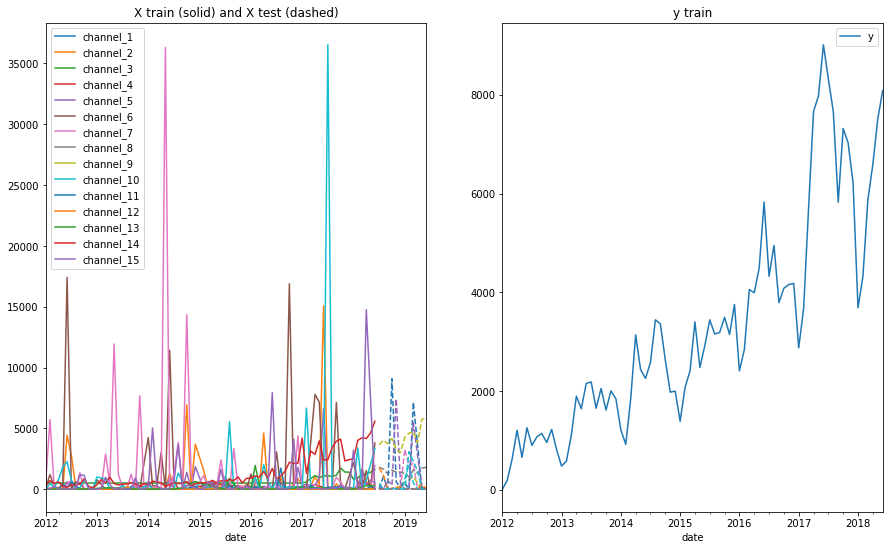

In [3]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,9))
axs = axs.ravel()
plt.subplots_adjust(wspace = 0.2)
axs[0].set_title('X train (solid) and X test (dashed)')
axs[1].set_title('y train')
X_train.plot(ax = axs[0])
X_test.plot(ax = axs[0], ls = '--', legend = False)
y_train.plot(ax = axs[1])


## Feature Selection

With the cleand data we can now focus on the feature engineering: we will select only these channels that are the best for the following analysis.

### Variance threshold

The first method for the feature selection that we will apply is variance thresholding. This method drops features with mostly the same values or with a very low variation. Such features make the model hard to learn and perform well. As there is no one good value of the variance threshold to put, we will test a few possibilities.

In [4]:
from sklearn.feature_selection import VarianceThreshold

def varth(threshold):
    var_threshold = VarianceThreshold(threshold = threshold)
    var_threshold.fit(X_train)
    sum(var_threshold.get_support()) 
    th_columns = [column for column in X_train.columns if column not in X_train.columns[var_threshold.get_support()]]
    return th_columns

for th in [0.0, 0.1, 0.5, 1.0]:   
    cols = varth(th)
    print('Columns below variance threshold = ' + str(th) + ' : \n' + str(cols))

Columns below variance threshold = 0.0 : 
[]
Columns below variance threshold = 0.1 : 
[]
Columns below variance threshold = 0.5 : 
['channel_8']
Columns below variance threshold = 1.0 : 
['channel_8', 'channel_9']


We can notice that depending on the variance threshold, a different number of columns is reported. Here we can make a conservative decision to use threshold = 0.0. It means that we cannot drop any features so far.

### Pairwise correlation between features

We can also print and plot the correlation matrix for the X train data.

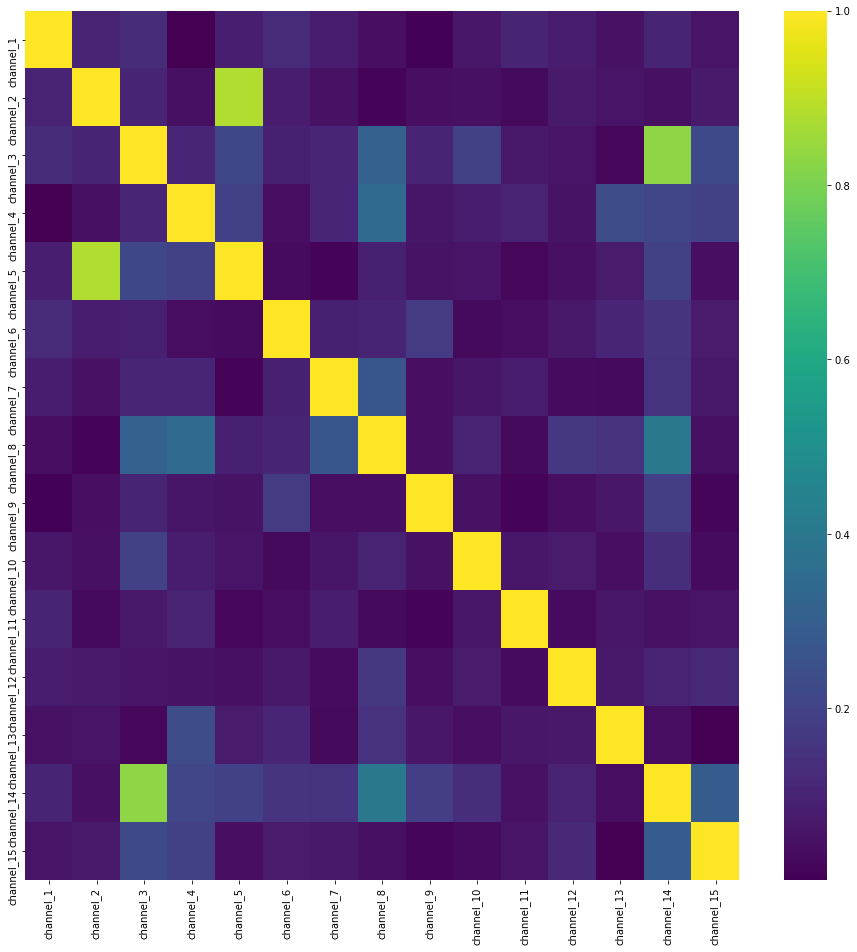

In [5]:
import seaborn as sns
corr_df = X_train.corr().abs()
corr_df
figure, ax_hm = plt.subplots(nrows = 1, ncols = 1, figsize = (16, 16))
sns.heatmap(corr_df, cmap = 'viridis', ax = ax_hm)
plt.show()

When variables are (highly) correlated with each other they can be considered redundant ones, as they do not add any new information to the output. In consequence, they can be dropped without losing a bigger picture of the input data.

Here we will print columns with a correlation higher than 0.8. As the correlation matrix is symmetrical, we can consider only the upper triangle (above the main diagonal) to make the analysis more robust.

In [6]:
upper_triangle = corr_df.where(np.triu(np.ones(corr_df.shape), k = 1).astype(np.bool))
high_corr = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.8)]
print('Columns with high correlation (> 0.8): \n' + str(high_corr))

X_train = X_train.drop(high_corr, axis=1)
display(X_train)

Columns with high correlation (> 0.8): 
['channel_5', 'channel_14']


,channel_1,channel_2,channel_3,channel_4,channel_6,channel_7,channel_8,channel_9,channel_10,channel_11,channel_12,channel_13,channel_15
date,,,,,,,,,,,,,
2012-01-01,0.000000,0.855201,507.292767,67.761324,102.682690,532.800200,0.000000,0.000000,14.379205,15.674800,7.678876,1.010454,100.565156
2012-02-01,1.035034,11.774970,507.292767,67.761324,1205.408087,5725.402460,0.942431,0.059616,464.512531,-0.851156,1.573847,1.010454,36.368318
2012-03-01,0.000000,6.150736,507.292767,67.761324,235.998029,11.597828,0.946789,0.000000,138.271983,0.184595,35.722658,1.010454,216.993157
2012-04-01,0.000000,154.188243,507.292767,67.761324,7.956306,18.029229,0.000000,0.000000,794.104038,6.207353,54.795837,8.525265,11.486971
2012-05-01,0.000000,4.072811,507.292767,56.732480,484.513722,14.587910,0.944704,0.000000,1831.859214,402.226841,55.747084,16.040076,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-01,0.000000,34.210456,937.810644,0.584182,511.146571,385.917488,0.000000,0.000000,3397.144050,91.857301,0.000000,97.342270,31.155605
2018-03-01,0.000000,1680.050998,1228.629386,738.399165,6.257846,195.790361,0.000000,0.000000,1.402489,0.066165,22.184036,190.109813,41.480070
2018-04-01,0.000000,633.736407,1271.085469,506.254436,1531.053562,5.663234,0.000000,0.000000,777.431029,-0.056477,1.279310,282.877356,14766.356900


We dropped two columns (channel_5 and channel_14), reducing number of dimensions by two.

### Correlation between features and target

If a variable has a very low correlation with the target, it’s not going to be useful for the model (prediction). Contrary to the pairwise correlation, where we removed highly-correlated features, here we can drop variables that have a very low correlation with the target. To do it, we need to again calculate the correlation matrix of the newly created (reduced) dataframe and then check the correlation with respect to the target column.

In [7]:
new_corr = abs(X_train.corrwith(y_train.y))
print(new_corr)

channel_1     0.105020
channel_2     0.214057
channel_3     0.790745
channel_4     0.195875
channel_6     0.121040
channel_7     0.109941
channel_8     0.456940
channel_9     0.071907
channel_10    0.267964
channel_11    0.122343
channel_12    0.086048
channel_13    0.026046
channel_15    0.220512
dtype: float64


We can notice that many remaining variables have a small correlation with the target. We can drop variables with a correlation smaller than 0.1.

In [8]:
small_corr = new_corr[(new_corr) < 0.1] 
display(small_corr.index) 
X_train = X_train.drop(small_corr.index, axis = 1)
display(X_train) 

Index(['channel_9', 'channel_12', 'channel_13'], dtype='object')

,channel_1,channel_2,channel_3,channel_4,channel_6,channel_7,channel_8,channel_10,channel_11,channel_15
date,,,,,,,,,,
2012-01-01,0.000000,0.855201,507.292767,67.761324,102.682690,532.800200,0.000000,14.379205,15.674800,100.565156
2012-02-01,1.035034,11.774970,507.292767,67.761324,1205.408087,5725.402460,0.942431,464.512531,-0.851156,36.368318
2012-03-01,0.000000,6.150736,507.292767,67.761324,235.998029,11.597828,0.946789,138.271983,0.184595,216.993157
2012-04-01,0.000000,154.188243,507.292767,67.761324,7.956306,18.029229,0.000000,794.104038,6.207353,11.486971
2012-05-01,0.000000,4.072811,507.292767,56.732480,484.513722,14.587910,0.944704,1831.859214,402.226841,0.000000
...,...,...,...,...,...,...,...,...,...,...
2018-02-01,0.000000,34.210456,937.810644,0.584182,511.146571,385.917488,0.000000,3397.144050,91.857301,31.155605
2018-03-01,0.000000,1680.050998,1228.629386,738.399165,6.257846,195.790361,0.000000,1.402489,0.066165,41.480070
2018-04-01,0.000000,633.736407,1271.085469,506.254436,1531.053562,5.663234,0.000000,777.431029,-0.056477,14766.356900


Here, with the very minimalistic selection, we reduced our dimensions by the next three by dropping channels 9, 12 and 13.

### RFE (Recursive Feature Elimination)

The Recursive Feature Elimination (RFE) method works by recursively removing attributes and building a model on those attributes that remain. It uses accuracy metric to rank the feature according to their importance. This section was inspired by [this article](https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b).

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 7)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train, y_train)  

#Fitting the data to model
model.fit(X_rfe, y_train)
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True False False  True False  True  True]
[1 1 1 1 3 4 1 2 1 1]


We took LinearRegression model with 7 features and RFE ranked them. Number 7 was arbitrary and we can test different number of features to find the most optimal one.

In [10]:
from sklearn.model_selection import train_test_split

#Number of features
nof_list = np.arange(1,10)            
high_score = 0

#Variable to store the optimum features
nof = 0           
score_list = []
for n in range(len(nof_list)):
    X_train_short, X_val, y_train_short, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model, nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_short, y_train_short)
    X_val_rfe = rfe.transform(X_val)
    model.fit(X_train_rfe, y_train_short)
    score = model.score(X_val_rfe, y_val)
    score_list.append(score)
    if(score > high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 7
Score with 7 features: 0.735729


We see that the optimal number of features is 7. Now we can check which channels are the best to consider:

In [11]:
cols = list(X_train.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 7)   

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train, y_train)  

#Fitting the data to model
model.fit(X_rfe, y_train)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp == True].index
print(selected_features_rfe)

#Keep only the best channels
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]

print(X_train)
#print(X_test)

Index(['channel_1', 'channel_2', 'channel_3', 'channel_4', 'channel_8',
       'channel_11', 'channel_15'],
      dtype='object')
            channel_1    channel_2    channel_3   channel_4  channel_8  \
date                                                                     
2012-01-01   0.000000     0.855201   507.292767   67.761324   0.000000   
2012-02-01   1.035034    11.774970   507.292767   67.761324   0.942431   
2012-03-01   0.000000     6.150736   507.292767   67.761324   0.946789   
2012-04-01   0.000000   154.188243   507.292767   67.761324   0.000000   
2012-05-01   0.000000     4.072811   507.292767   56.732480   0.944704   
...               ...          ...          ...         ...        ...   
2018-02-01   0.000000    34.210456   937.810644    0.584182   0.000000   
2018-03-01   0.000000  1680.050998  1228.629386  738.399165   0.000000   
2018-04-01   0.000000   633.736407  1271.085469  506.254436   0.000000   
2018-05-01   0.170354    96.035479  1394.304796  274.109

Finally, we have our best seven features: channels 1, 2, 3, 4, 8, 11 and 15. Now we can standarise our data.

In [12]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train.values)
X_test_sc = sc.transform(X_test.values)
X_train = pd.DataFrame(X_train_sc, index = X_train.index, columns = X_train.columns)
X_test = pd.DataFrame(X_test_sc, index = X_test.index, columns = X_test.columns)

## Forecasting

We perform forecasting by using three different methods, namely: Linear Regression, Gradient Boosting and Decision Tree. Each model is evaluated in the term of WMAPE (weighted mean absolute percentage error) metric, defined as:

In [13]:
#Calculate WMAPE
def wmape(y, yhat):
# Take two series and calculate the wmape from it
    wmape = sum(abs(y - yhat)) / sum(y) * 100.0
    return wmape

To control how well methods work, let us split our data to the training set (80%) and validation set (20%): 

In [14]:
X_train_short, X_val, y_train_short, y_val = train_test_split(X_train, y_train, test_size = 0.2,random_state = 0)
X_val = X_val.sort_index()
y_val = y_val.sort_index()

### Linear regression

Simply speaking, a linear regression is a statistical practice of calculating a straight line that specifies a mathematical relationship between variables (X) and target (y).

In [15]:
# Initialise the model
lr = LinearRegression() 
    
# Fit the model
lr.fit(X_train_short, y = y_train_short)  
    
# Make predictions
lr_pred_val = lr.predict(X_val)
lr_pred = lr.predict(X_test)
yv_lr = y_val['y'].values
lr_pred_val = lr_pred_val.T
lr_pred_val = lr_pred_val.ravel()
lr_wmape = wmape(yv_lr, lr_pred_val)

print ('WMAPE: %.2f%%' % lr_wmape)

WMAPE: 24.52%


We reached mean error (WMAPE) around 25%. Not bad. Now let us visualise results:

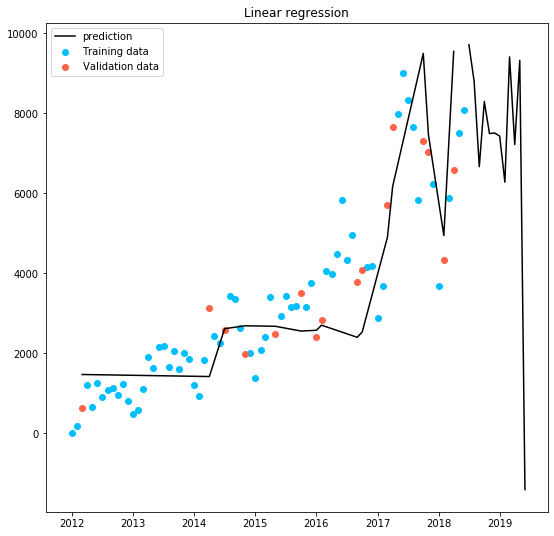

In [16]:
fig, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize = (9,9))
ax1.scatter(x = y_train_short.index, y = y_train_short['y'], color = 'deepskyblue', label = 'Training data')
ax1.scatter(x = y_val.index, y = y_val['y'], color = 'tomato', label = 'Validation data')
ax1.plot(y_val.index, lr_pred_val, c = 'black', label = 'prediction')
ax1.plot(X_test.index, lr_pred, c = 'black')
ax1.set_title('Linear regression')
ax1.legend(loc='upper left')
plt.show()

For the end we can print 

In [17]:
print('Coefficients:') 
print(lr.coef_.T)
print('Intercept: ' + str(lr.intercept_))

Coefficients:
[[ -37.38360676]
 [ 318.28261661]
 [1647.22554153]
 [  38.40379524]
 [-495.49848599]
 [ 179.45944792]
 [ 388.19239143]]
Intercept: [3285.57289433]


### Gradient Boosting

Gradient boosting relies on the intuition that the best possible next model, when combined with previous models, minimizes the overall prediction error.

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialise the model
gbr = GradientBoostingRegressor()

# Fit the model
gbr.fit(X_train_short, y = y_train_short)  
    
# Make predictions
gbr_pred_val = gbr.predict(X_val)
gbr_pred = gbr.predict(X_test)
yv_gbr = y_val['y'].values
gbr_pred_val = gbr_pred_val.T
gbr_pred_val = gbr_pred_val.ravel()
gbr_wmape = wmape(yv_gbr, gbr_pred_val)

print ('WMAPE: %.2f%%' % gbr_wmape)

WMAPE: 23.41%


We have a slightly better WMAPE in comparison to the Linear Regression model. We can try a hyperparameter tuning to check if we can improve this result even more. First, let us check which arguments of the gradient boost can be tuned:

In [19]:
print(gbr.get_params().keys())

dict_keys(['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'presort', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])


Now we can evaluate our model on the grid of hyperparameters. Due to the limited computational resources, here we will check only a few of them:

In [20]:
from sklearn.model_selection import GridSearchCV
parameters = {'criterion' : ['friedman_mse', 'squared_error'],
              'learning_rate' : [0.01, 0.05, 0.1, 0.5],
              'loss' : ['squared_error', 'absolute_error', 'huber', 'quantile'], 
              'n_estimators' : [10, 20, 30, 40, 50],
}
GB_rg = GridSearchCV(gbr, parameters, cv = 5)
GB_rg.fit(X_train, y_train)
print(f'Best parameters: {GB_rg.best_params_}')
print(f'Accuracy score of the best_estimator: ' + f'{GB_rg.best_score_:.3f}')

Best parameters: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'huber', 'n_estimators': 40}
Accuracy score of the best_estimator: -6.679


Now we can evaluate model with the best hyperparameters and check if WMAPE improves:

In [21]:
gbr_best = GradientBoostingRegressor(criterion = 'friedman_mse', 
                                     learning_rate = 0.1, 
                                     loss = 'huber', 
                                     n_estimators = 40)
# Fit the model
gbr_best.fit(X_train_short, y = y_train_short)  
    
# Make predictions
gbr_pred_val = gbr_best.predict(X_val)
gbr_pred = gbr_best.predict(X_test)
yv_gbr = y_val['y'].values
gbr_pred_val = gbr_pred_val.T
gbr_pred_val = gbr_pred_val.ravel()
gbr_wmape = wmape(yv_gbr, gbr_pred_val)

print ('WMAPE: %.2f%%' % gbr_wmape)

WMAPE: 22.60%


Yes! We improved WMAPE a little bit!

We can also perform a quantile regression analysis to check uncertainties of our predictions:

In [22]:
#Create models for lower and upper intervals
lower_model = GradientBoostingRegressor(loss = "quantile", 
                                        alpha = 0.1,
                                        criterion = 'friedman_mse',
                                        learning_rate = 0.1,
                                        n_estimators = 40)
upper_model = GradientBoostingRegressor(loss = "quantile", 
                                        alpha = 0.9,
                                        criterion = 'friedman_mse',
                                        learning_rate = 0.1,
                                        n_estimators = 40)
 
#Fit models
lower_model.fit(X_train_short, y = y_train_short)
upper_model.fit(X_train_short, y = y_train_short)
 
#Predict and write to dataframe
predictions1 = pd.DataFrame(y_val.index)
predictions1['lower'] = lower_model.predict(X_val)
predictions1['upper'] = upper_model.predict(X_val)
predictions1 = predictions1.set_index('date')

predictions2 = pd.DataFrame(X_test.index)
predictions2['lower'] = lower_model.predict(X_test)
predictions2['upper'] = upper_model.predict(X_test)
predictions2 = predictions2.set_index('date')
 
print(predictions1)
print(predictions2)

                  lower        upper
date                                
2012-03-01   937.588418  4260.727599
2014-04-01  1184.020555  4260.727599
2014-07-01  1199.311120  4287.660312
2014-11-01  1095.936725  4321.792952
2015-05-01  1199.311120  3959.484553
2015-10-01   675.296055  3959.484553
2016-01-01   651.357445  4260.727599
2016-02-01  1199.311120  4294.108130
2016-09-01   930.025859  4260.727599
2016-10-01   952.878982  4260.727599
2017-03-01  1096.947838  3992.865084
2017-04-01  1199.311120  8389.691498
2017-10-01  1319.515740  6559.679274
2017-11-01  1342.368863  6865.202022
2018-02-01  1342.368863  7738.352658
2018-04-01  1199.311120  6176.200706
                  lower        upper
date                                
2018-07-01  1007.678078  6952.450943
2018-08-01   742.113529  7113.854126
2018-09-01  1176.457997  6429.616413
2018-10-01  1199.311120  7030.928347
2018-11-01  1199.311120  7833.479748
2018-12-01   952.878982  7887.581484
2019-01-01  1199.311120  6207.168077
2

We can visualise the results:

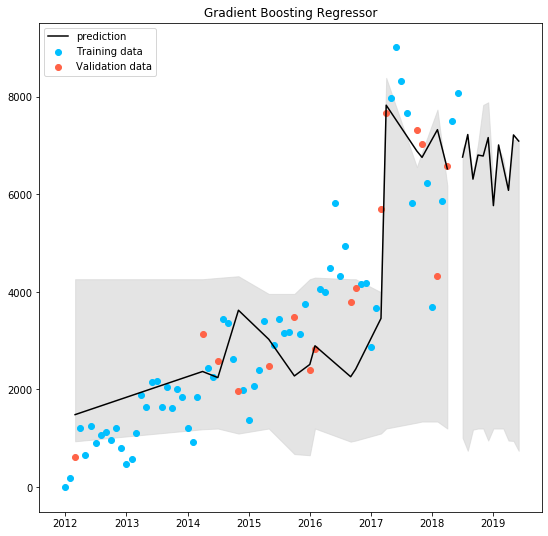

In [23]:
fig, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize = (9,9))
ax1.fill_between(predictions1.index, predictions1['upper'], predictions1['lower'], color = 'lightgrey', alpha = '0.6')
ax1.fill_between(predictions2.index, predictions2['upper'], predictions2['lower'], color = 'lightgrey', alpha = '0.6')
ax1.scatter(x = y_train_short.index, y = y_train_short['y'], color = 'deepskyblue', label = 'Training data')
ax1.scatter(x = y_val.index, y = y_val['y'], color = 'tomato', label = 'Validation data')
ax1.plot(y_val.index, gbr_pred_val, c = 'black', label = 'prediction')
ax1.plot(X_test.index, gbr_pred, c = 'black')
ax1.set_title('Gradient Boosting Regressor')
ax1.legend(loc='upper left')
plt.show()

### Decision Tree

A decision tree is a decision support tool that uses a tree-like model of decisions and their possible consequences. It is one way to display an algorithm that only contains conditional control statements.

In [24]:
from sklearn.tree import DecisionTreeRegressor

# Initialise the model
dt = DecisionTreeRegressor()
   
# Fit the model
dt.fit(X_train_short, y = y_train_short)  
    
# Make predictions
dt_pred_val = dt.predict(X_val)
dt_pred = dt.predict(X_test)
yv_dt = y_val['y'].values
dt_pred_val = dt_pred_val.T
dt_pred_val = dt_pred_val.ravel()
dt_wmape = wmape(yv_dt, dt_pred_val)

print ('WMAPE: %.2f%%' % dt_wmape)

WMAPE: 36.62%


This is the worst result among these three methods. We will not proceed with this model.